In [1]:
import numpy as np
import torch
from tuned_lens.nn.lenses import TunedLens, LogitLens
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
from tuned_lens.plotting import PredictionTrajectory
from IPython.display import display, Markdown
from tqdm import tqdm
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")
from joblib import Parallel, delayed
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from dadapy import data
from dadapy.data import Data
import scipy

from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import matplotlib.colors as mcolors
hex6 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
colors6=[mcolors.to_rgb(i) for i in hex6]
from scipy.spatial.distance import pdist, squareform

g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Disabled automatic differentiation


In [2]:
model = AutoModelForCausalLM.from_pretrained('gpt2-large', device_map="auto")
device = torch.device('cuda')
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
tuned_lens = TunedLens.from_model_and_pretrained(model)
tuned_lens = tuned_lens.to(device)

/users/viswanat/.local/lib/python3.10/site-packages/tuned_lens/nn/lenses.py:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = th.load(ckpt_path, **th_load_kwargs)


In [3]:
ds = load_dataset("NeelNanda/pile-10k")['train']
filtered_indices = np.load('../filtered_indices.npy')
subset_indices = np.load('../subset_indices.npy')

In [4]:
def shuffle_tokens(ids, shuffle_index):
    N, K = ids.shape[-1], 4**shuffle_index
    block_size = N//K
    permutation = np.random.permutation(K)
    new_ids = ids.reshape((1, K, block_size))
    new_ids = new_ids[0, permutation, :]
    new_ids = new_ids.reshape(1, N)
    return new_ids
    
def get_logits(test_sequence, max_length = 256, lens = tuned_lens, shuffle_indx = 0):
    input_ids = tokenizer.encode(test_sequence.strip(), add_special_tokens = False, \
                         return_tensors = "pt", max_length = max_length, truncation = True)
    # if shuffled:
    input_ids = shuffle_tokens(input_ids, shuffle_indx).to(device)
    all_logits = []
    all_probs = []
    with torch.no_grad():
        # input_ids_th = torch.tensor(input_ids.clone().detach(), dtype=torch.int64, device=model.device)
        input_ids_th = input_ids.clone().detach().to(model.device)
        outputs = model(input_ids_th, output_hidden_states=True)
        stream = list(outputs.hidden_states)
        # Create the stream of log probabilities from the lens
        for i, h in enumerate(stream[:-1]):
            logits = lens.forward(h, i).squeeze()
            probs = torch.nn.functional.softmax(logits, dim = -1)
            all_logits.append(logits)
            all_probs.append(probs)
        all_logits.append(outputs.logits.squeeze())
        all_probs.append(torch.nn.functional.softmax(outputs.logits.squeeze(), dim = -1))
        return all_logits, all_probs

def calculate_moments(all_logits, all_probs):
    all_probs_com = []
    all_logits_com = []
    n_layers = len(all_logits)
    all_entropies = []
    with torch.no_grad():
        for idx in range(n_layers):
            logits, probs = all_logits[idx], all_probs[idx]
            probs_com = torch.mean(probs, axis = -2).squeeze()
            all_probs_com.append(probs_com)
            logits_com = torch.log(probs_com)
            logits_com_mean = torch.sum(probs_com * logits_com)
            all_logits_com.append(logits_com - logits_com_mean)
            all_entropies.append(-(probs*torch.log(probs)).sum(axis = -1).cpu().detach().numpy())
        
        all_probs_com = torch.stack(all_probs_com, axis = 0)
        all_logits_com = torch.stack(all_logits_com, axis = 0)
    all_cumulants = []
    with torch.no_grad():
        for idx in range(n_layers):
            delta_logits = all_logits_com[idx] - all_logits[idx]
            centered_delta_logits = delta_logits - (all_probs[idx] * delta_logits).sum(axis = -1, keepdims = True)
            m1 = (all_probs[idx] * (centered_delta_logits)).sum(axis = -1)
            m2 = (all_probs[idx] * (centered_delta_logits**2)).sum(axis = -1)
            m3 = (all_probs[idx] * (centered_delta_logits**3)).sum(axis = -1)
            m4 = (all_probs[idx] * (centered_delta_logits**4)).sum(axis = -1)
            m5 = (all_probs[idx] * (centered_delta_logits**5)).sum(axis = -1)
            m6 = (all_probs[idx] * (centered_delta_logits**6)).sum(axis = -1)
            m7 = (all_probs[idx] * (centered_delta_logits**7)).sum(axis = -1)
            m8 = (all_probs[idx] * (centered_delta_logits**8)).sum(axis = -1)
            
            # print(variance.shape)
            k2 = torch.mean(m2)
            k3 = torch.mean(m3)
            k4 = torch.mean(m4 - 3*m2**2)
            k5 = torch.mean(m5 - 10*m2*m3)
            k6 = torch.mean(m6 - 15*m2*m4 - 10 * m3 **2 + 30 * m2**3)
            k7 = torch.mean(m7 - 21 * m2 * m5 - 35 * m3 * m4 + 210* (m2**2) * m3)
            k8 = torch.mean(m8 - 28 * m2 * m6 - 56 * m3 * m5 + 420 * m2**2 * m4 - 35 * m4 * m4 + 560 * m2 * m3 * m3 - 630 * m2**4)
    #         cumulant5 = (moments[5] - 10 * moments[3]*moments[2]).mean()
            
            all_cumulants.append(torch.stack([k2, k3, k4, k5, k6, k7, k8]))
    return all_cumulants, all_probs_com

In [5]:
def plot_stats(test_indx, ax):
    prompt_indx = filtered_indices[test_indx]
    topic = ds['meta'][prompt_indx]
    test_sequence = ds['text'][prompt_indx].strip()
    all_logits, all_probs = get_logits(test_sequence, max_length = max_length)
    all_cumulants, all_probs_com = calculate_moments(all_logits, all_probs)
    entropy = -torch.sum(all_probs_com * torch.log(all_probs_com + 1e-12), axis = -1).cpu().detach().numpy()
    all_cumulants_np = torch.stack(all_cumulants).cpu().detach().numpy()/np.array([2, 6, 24, 120, 720, 5040, 40320])
    for idx in range(7):
        plt.plot(all_cumulants_np.T[idx], marker = '.', label = idx + 2)
    # plt.plot(np.array(all_entropies).mean(axis = -1), marker = '.', c = 'black', linestyle = '-')
    ax.axvline(16, c = 'red', linestyle = 'dotted')
    ax.set_title(topic)
    ax.grid(True)
    ax.legend()
    

In [6]:
max_length = 256

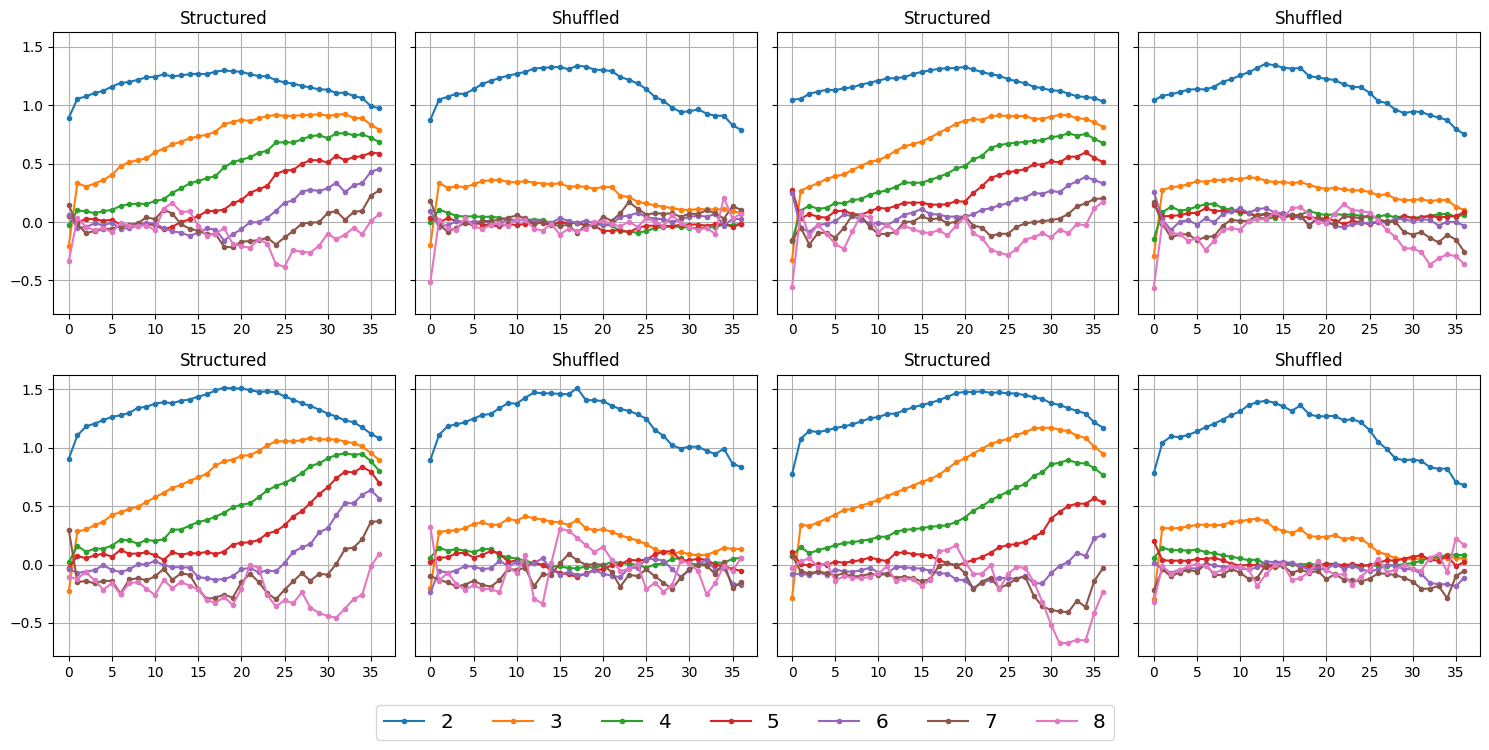

In [7]:
def plot_stats(test_indx, ax, shuffle_indx = 0):
    prompt_indx = filtered_indices[test_indx]
    topic = ds['meta'][prompt_indx]['pile_set_name']
    test_sequence = ds['text'][prompt_indx].strip()
    all_logits, all_probs = get_logits(test_sequence, max_length = max_length, shuffle_indx = shuffle_indx)
    all_cumulants, all_probs_com = calculate_moments(all_logits, all_probs)
    entropy = -torch.sum(all_probs_com * torch.log(all_probs_com + 1e-12), axis = -1).cpu().detach().numpy()
    all_cumulants_np = torch.stack(all_cumulants).cpu().detach().numpy()/np.array([2, 6, 24, 120, 720, 5040, 40320])
    for idx in range(7):
        ax.plot(all_cumulants_np.T[idx], marker = '.', label = idx + 2)
    # plt.plot(np.array(all_entropies).mean(axis = -1), marker = '.', c = 'black', linestyle = '-')
    # ax.axvline(16, c = 'red', linestyle = 'dotted')
    # ax.set_title(f"{prompt_indx}, {topic}")
    shuffled = "Shuffled" if shuffle_indx > 0 else "Structured"
    ax.set_title(shuffled)
    ax.grid(True)
    # ax.legend()

fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharey = True)
for qq, indx in enumerate(np.random.choice(2244, 4)): 
    # for shuffle_indx in range(5): plot_stats(indx, axes[qq][shuffle_indx], shuffle_indx)
    plot_stats(indx, axes[qq//2][qq%2*2], 0)
    plot_stats(indx, axes[qq//2][qq%2*2 + 1], 4)
handles_psim, labels_psim = axes[0, 0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = 7,  fontsize = "x-large")
plt.tight_layout()
plt.show()

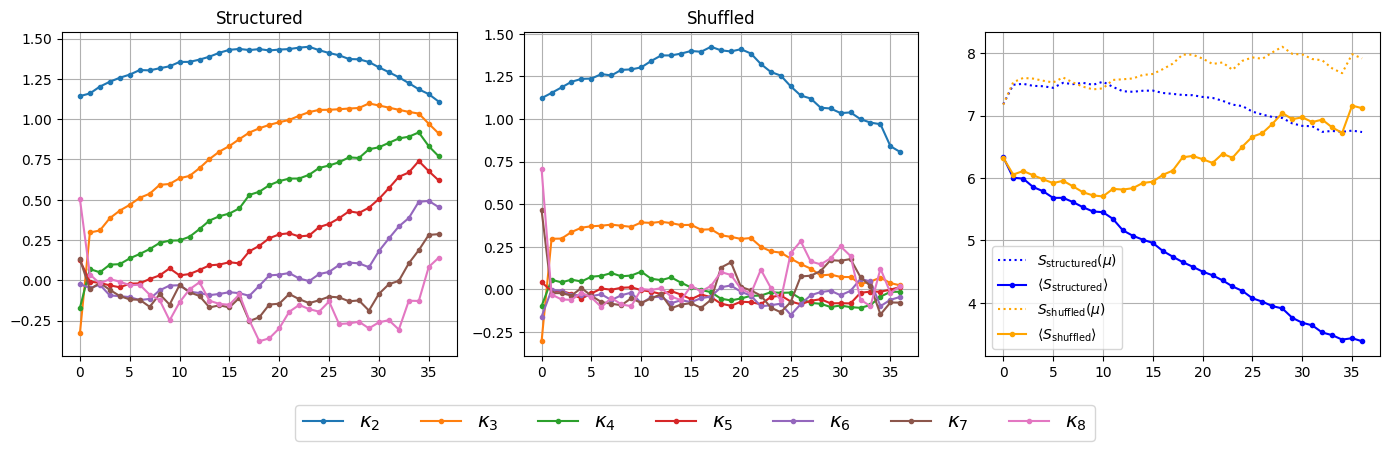

In [8]:
def plot_stats(test_indx, ax, shuffle_indx = 0):
    prompt_indx = filtered_indices[test_indx]
    topic = ds['meta'][prompt_indx]['pile_set_name']
    test_sequence = ds['text'][prompt_indx].strip()
    all_logits, all_probs = get_logits(test_sequence, max_length = max_length, shuffle_indx = shuffle_indx)
    all_cumulants, all_probs_com = calculate_moments(all_logits, all_probs)
    entropy = -torch.sum(all_probs_com * torch.log(all_probs_com + 1e-12), axis = -1).cpu().detach().numpy()
    all_cumulants_np = torch.stack(all_cumulants).cpu().detach().numpy()/np.array([2, 6, 24, 120, 720, 5040, 40320])
    for idx in range(7):
        ax.plot(all_cumulants_np.T[idx], marker='.', label=f'$\kappa_{{{idx + 2}}}$')
    # plt.plot(np.array(all_entropies).mean(axis = -1), marker = '.', c = 'black', linestyle = '-')
    # ax.axvline(16, c = 'red', linestyle = 'dotted')
    # ax.set_title(f"{prompt_indx}, {topic}")
    shuffled = "Shuffled" if shuffle_indx > 0 else "Structured"
    ax.set_title(shuffled)
    ax.grid(True)
    all_entropies= []
    for idx in range(len(all_logits)):
        # print("Hi")
        logits, probs = all_logits[idx], all_probs[idx].cpu().detach().numpy()
        all_entropies.append(-(probs*np.log(probs)).sum(axis = -1).mean())
    return entropy, all_entropies
    # ax.legend()

test_indx = np.random.choice(2244, 1)[0]

test_indx = 686
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
# for qq, test_indx in enumerate(np.random.choice(2244, 1)): 
    # for shuffle_indx in range(5): plot_stats(indx, axes[qq][shuffle_indx], shuffle_indx)
entropy, all_entropies = plot_stats(test_indx, axes[0], 0)
axes[2].plot(entropy, c = 'blue', linestyle = 'dotted',label = "$S_{\\text{structured}}(\mu)$")
axes[2].plot(all_entropies, marker = '.', c = 'blue', label = "$\langle S_{\\text{structured}} \\rangle$")
entropy, all_entropies = plot_stats(test_indx, axes[1], 4)
axes[2].plot(entropy, c = 'orange', linestyle = 'dotted', label = "$S_{\\text{shuffled}}(\mu)$")
axes[2].plot(all_entropies, marker = '.', c = 'orange', label = "$\langle S_{\\text{shuffled}} \\rangle$")
axes[2].grid(True)
axes[2].legend()
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = 7,  fontsize = "x-large")
plt.tight_layout()
plt.show()

## Finding histogram of $\delta X$ (and verifying the cumulants)
1. Lets take a layer = 20, test_indx = 686
2. Find the histogram of $\delta X$
3. Find the cumulants and cerify that it matches the average of cumulants

Here we verify if the cumulants of $\delta X$ is related to the average token wise cumulants, i.e.,
$$\sum_{i} \kappa_n(\delta x_i) = \kappa_n(\sum_i \delta x_i) = \kappa_n(\delta X)$$

### Utils

In [9]:
import pandas as pd
def simulate_sums(centered_delta_logits: torch.Tensor,
                  probs: torch.Tensor,
                  n_sims: int = 10000,
                  bins: int = 50,
                  density: bool = True):
    T, V = probs.shape

    # 1) Sample indices j_t for each token t, for each sim
    #    -> shape (T, n_sims)
    idx = torch.multinomial(probs, n_sims, replacement=True)
    # print(idx.shape)
    # 2) Gather the corresponding deltas -> (T, n_sims)
    sampled = torch.gather(centered_delta_logits, dim=1, index=idx)

    # 3) Sum across tokens -> (n_sims,)
    sums = sampled.sum(dim=0)

    # 4) Move to CPU & histogram
    sums_np = sums.cpu().numpy()
    hist, bin_edges = np.histogram(sums_np, bins=bins, density=density)

    return sums_np, hist, bin_edges

def plot_monte_carlo(test_indx, shuffle_indx = 0, LNUM = 20):
    prompt_indx = filtered_indices[test_indx]
    topic = ds['meta'][prompt_indx]['pile_set_name']
    test_sequence = ds['text'][prompt_indx].strip()
    input_ids = tokenizer.encode(test_sequence.strip(), add_special_tokens = False, \
                         return_tensors = "pt", max_length = max_length, truncation = True)
    input_ids = shuffle_tokens(input_ids, shuffle_indx).to(device)
    input_ids_th = input_ids.clone().detach().to(model.device)
    outputs = model(input_ids_th, output_hidden_states=True)
    stream = list(outputs.hidden_states)
    logits = tuned_lens.forward(stream[LNUM], LNUM).squeeze()
    probs = torch.nn.functional.softmax(logits, dim = -1)
    probs_com = torch.mean(probs, axis = 0)
    logits_com_mean = torch.sum(probs_com * torch.log(probs_com))
    logits_com_centered = (torch.log(probs_com) - logits_com_mean).unsqueeze(0) 
    delta_logits = logits_com_centered - logits # -\delta X
    centered_delta_logits = delta_logits - (probs * delta_logits).sum(axis = 1, keepdims = True) # Physicists like to call this "gauge fixing".
    sums, hist, edges = simulate_sums(centered_delta_logits,
                                      probs,
                                      n_sims=10000000,
                                      bins=1000,
                                      density=True)
    # p_dist = np.histogram()
    mean = sums.mean()
    m2_emp = ((sums-mean)**2).mean()
    m3_emp = ((sums-mean)**3).mean()
    m4_emp = ((sums-mean)**4).mean()
    
    # 2) form cumulants
    k1_emp = mean
    k2_emp = m2_emp/max_length/2
    k3_emp = m3_emp/max_length/6
    k4_emp = (m4_emp - 3 * m2_emp**2)/max_length/24
    
    # print(f"Empirical cumulants:\n"
    #     #  f"  k1 = {k1_emp:.4f}\n"
    #       f"  k2 = {k2_emp:.4f}\n"
    #       f"  k3 = {k3_emp:.4f}\n"
    #       f"  k4 = {k4_emp:.4f}")
    
    centers = 0.5*(edges[:-1] + edges[1:])  # (B,)
    # plt.figure()
    is_shuffled = "shuffled" if shuffle_indx else "structured"
    plt.step(centers, hist, where='mid', label = is_shuffled)
    
    all_cumulants, all_probs_com = calculate_moments(logits.unsqueeze(0), probs.unsqueeze(0))
    norm_factors = np.array([2, 6, 24, 120, 720, 5040, 40320], dtype=np.float32)

    model_cumulants = torch.stack(all_cumulants)[0].cpu().detach().numpy()  # chi_2 to chi_4
    model_chi = model_cumulants / norm_factors
    # Make DataFrame with comparison
    df = pd.DataFrame([{
            # "test_indx": test_indx,
            # "shuffle_indx": shuffle_indx,
            "type": is_shuffled,
            r"$\kappa_2$ (monte carlo)": k2_emp,
            r"$\kappa_2$ (avg of tokens)": model_chi[0],
            r"$\kappa_3$ (monte carlo)": k3_emp,
            r"$\kappa_3$ (avg of tokens)": model_chi[1],
            r"$\kappa_4$ (monte carlo)": k4_emp,
            r"$\kappa_4$ (avg of tokens)": model_chi[2]
        }])
    return df

### Simulating $\delta X$

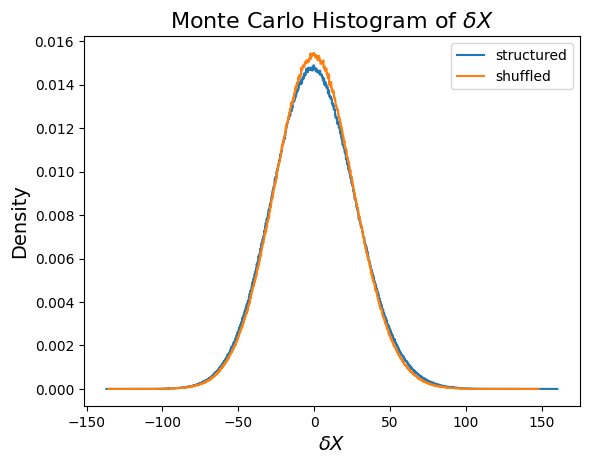

In [15]:
df1 = plot_monte_carlo(test_indx = 686, shuffle_indx = 0, LNUM = 20)  
df2 = plot_monte_carlo(test_indx = 686, shuffle_indx = 4, LNUM = 20)  
plt.legend()
plt.xlabel(r"$\delta X$", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title(r"Monte Carlo Histogram of $\delta X$", fontsize=16)
plt.show()

In [17]:
display(Markdown(r"#### Comparing cumulants obtained by simulating $\delta X$ and considering the average of token-wise cumulants"))
df_combined = pd.concat([df1, df2], ignore_index=True).round(3)
display(df_combined)

#### Comparing cumulants obtained by simulating $\delta X$ and considering the average of token-wise cumulants

,type,$\kappa_2$ (monte carlo),$\kappa_2$ (avg of tokens),$\kappa_3$ (monte carlo),$\kappa_3$ (avg of tokens),$\kappa_4$ (monte carlo),$\kappa_4$ (avg of tokens)
0,structured,1.432,1.432,0.989,0.981,0.343,0.616
1,shuffled,1.322,1.322,0.334,0.332,0.039,0.017


#### Takeaway: The observable $\sum_{i} \kappa_n(\delta x_i)$ can be alternatively obtained by looking at the probability density of $\delta X$

